# Image Classification

This notebook demonstrates a simple image classification problem, sorting pictures of cats and dogs.

Credit to this notebook as basis for inspiration: https://www.kaggle.com/code/faressayah/chest-x-ray-medical-diagnosis-with-deep-learning

Data can be found here: https://www.kaggle.com/competitions/dogs-vs-cats/data

## Importing libraries

In [1]:
import sys
  
  
print("User Current Version:-", sys.version)

User Current Version:- 3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:05:16) 
[Clang 12.0.1 ]


In [2]:
# ! pip install scikit-learn

In [3]:
import pandas as pd 
import numpy as np 
import os
import random

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense,MaxPooling2D, MaxPool2D, Conv2D,Flatten,Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img


## Loading data

In [5]:
# %time
# import zipfile

# zip_files = ['test1', 'train']

# for zip_file in tqdm(zip_files):
#     with zipfile.ZipFile("./data/dogs-vs-cats/{}.zip".format(zip_file), "r") as z:
#         z.extractall('.') # unzip
#         print("{} unzipped".format(zip_file))

In [6]:
# Creating train directories

# os.makedirs("data/dogs-vs-cats/train/dog", exist_ok=True)
# os.makedirs("data/dogs-vs-cats/train/cat", exist_ok=True)

 
# filenames=os.listdir("data/dogs-vs-cats/train")
# for filename in filenames:
#     if '.' in filename:
#         category=filename.split('.')[0]
#         try:
#             if category=='dog':
#                 os.replace("data/dogs-vs-cats/train/" + filename, "data/dogs-vs-cats/train/dog/{}".format(filename))
#             else:
#                 os.replace("data/dogs-vs-cats/train/" + filename, "data/dogs-vs-cats/train/cat/{}".format(filename))
#         except Exception as e:
#             print(e)


In [7]:
# Creating validation directories

# os.makedirs('data/dogs-vs-cats/val', exist_ok=True)
# os.makedirs('data/dogs-vs-cats/val/cat', exist_ok=True)
# os.makedirs('data/dogs-vs-cats/val/dog', exist_ok=True)


# dog_file_list = os.listdir('data/dogs-vs-cats/train/dog')
# cat_file_list = os.listdir('data/dogs-vs-cats/train/cat')

# dog_train_size = len(dog_file_list)
# cat_train_size = len(cat_file_list)
# dog_val_size = int(dog_train_size/5)
# cat_val_size = int(cat_train_size/5)

# print("dog_train_size = {}".format(dog_train_size))
# print("cat_train_size = {}".format(cat_train_size))
# print("dog_val_size = {}".format(dog_val_size))
# print("cat_val_size = {}".format(cat_val_size))

# import random
# dog_val_sample = random.sample(dog_file_list, dog_val_size)
# cat_val_sample = random.sample(cat_file_list, cat_val_size)

# for dog in dog_val_sample:
#     os.replace("data/dogs-vs-cats/train/dog/{}".format(dog), "data/dogs-vs-cats/val/dog/{}".format(dog))
    
# for cat in cat_val_sample:
#     os.replace("data/dogs-vs-cats/train/cat/{}".format(cat), "data/dogs-vs-cats/val/cat/{}".format(cat))


dog_train_size = 10000
cat_train_size = 10000
dog_val_size = 2000
cat_val_size = 2000


In [ ]:
# Creating test directory

# test_images = os.listdir('./data/dogs-vs-cats/test1')
# os.makedirs('./data/dogs-vs-cats/test1/test', exist_ok=True)

# for image in test_images:
#     os.replace("./data/dogs-vs-cats/test1/{}".format(image), "./data/dogs-vs-cats/test1/test/{}".format(image))

## EDA

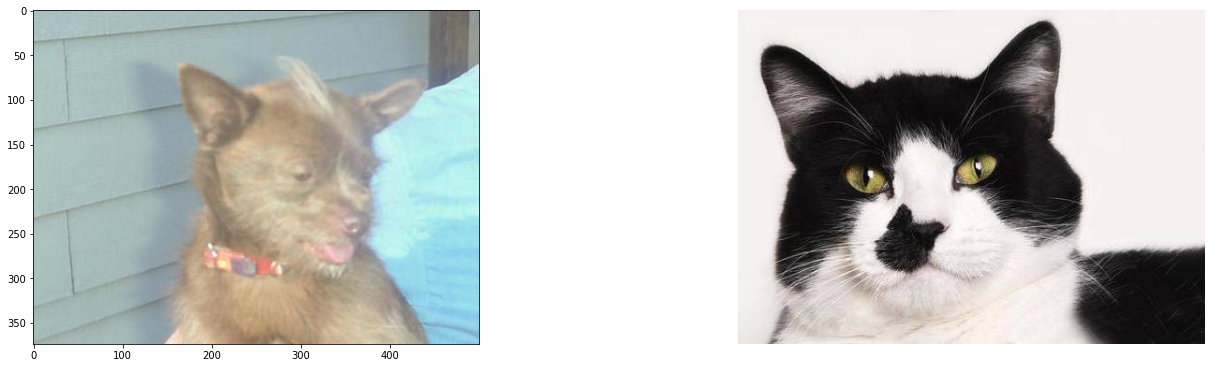

In [10]:
# Plotting samples

plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
sample = random.choice(dog_val_sample)
image = load_img("data/dogs-vs-cats/val/dog/"+sample)
plt.imshow(image)

plt.subplot(2, 2, 2)
sample = random.choice(cat_val_sample)
image = load_img("data/dogs-vs-cats/val/cat/"+sample)
plt.imshow(image)

plt.axis('off')

plt.tight_layout()

Width: 398 pixels, Height: 499 pixels
Max pixel value: 255, Min pixel value: 0
Mean pixel value: 114.80889752704739, Standard Deviation: 64.86643686060879


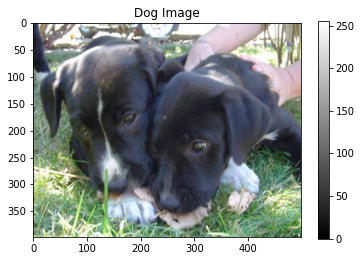

In [36]:
# Pixel analysis

sample = random.choice(dog_val_sample)
sample_img = plt.imread("data/dogs-vs-cats/val/dog/"+sample)
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Dog Image')

print("Width: {} pixels, Height: {} pixels".format(sample_img.shape[0], sample_img.shape[1]))
print("Max pixel value: {}, Min pixel value: {}".format(sample_img.max(), sample_img.min()))
print("Mean pixel value: {}, Standard Deviation: {}".format(sample_img.mean(), sample_img.std()))

/Users/tunjiogunbiyi/miniforge3/envs/mlp/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

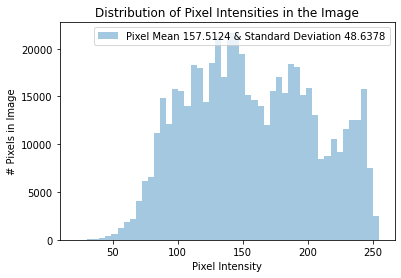

In [12]:
# Pixel distribution

import seaborn as sns

sns.distplot(sample_img.ravel(),
             label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}", 
             kde=False)
plt.legend(loc='upper right')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [13]:
# Building data generators for easier data augmentation. Validation generator has samplewise settings set to False because this information will not be available during test time

train_image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

val_image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=False,
    samplewise_std_normalization=False
)

In [15]:
# Setting data sources

train = train_image_generator.flow_from_directory("data/dogs-vs-cats/train", 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(320, 320))

validation = val_image_generator.flow_from_directory("data/dogs-vs-cats/val", 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(320, 320))

Found 16000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.


In [16]:
test = val_image_generator.flow_from_directory("data/dogs-vs-cats/test1", 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(320, 320))

Found 12500 images belonging to 1 classes.


## Run and evaluate model

Here we are training a simple CNN and measuring its performance against a validation set of data

In [ ]:
# For TPU training

# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# # instantiating the model in the strategy scope creates the model on the TPU
# with tpu_strategy.scope():

#     model = Sequential()

#     model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(320, 320, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(320, 320, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D(pool_size=(2, 2)))

#     model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D(pool_size=(2, 2)))

#     model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D(pool_size=(2, 2)))

#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.2))

#     model.add(Dense(1, activation='sigmoid'))

#     model.compile(loss='binary_crossentropy', 
#                   optimizer='adam', 
#                   metrics=['accuracy'])

In [37]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(320, 320, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(320, 320, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 318, 318, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 318, 318, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 316, 316, 32)      9248      
                                                                 
 batch_normalization_7 (Batc  (None, 316, 316, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 158, 158, 32)     0         
 2D)                                                             
                                                      

In [39]:
r = model.fit(
    train, 
    epochs=10,
    validation_data=validation, 
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10


2022-07-13 17:28:01.381771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 12.1719 - accuracy: 0.5188

2022-07-13 17:28:30.291267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 30s 285ms/step - loss: 12.1719 - accuracy: 0.5188 - val_loss: 7352.9648 - val_accuracy: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 28s 278ms/step - loss: 1.3157 - accuracy: 0.5500 - val_loss: 1031.6257 - val_accuracy: 0.0800
Epoch 3/10
100/100 [==============================] - 28s 280ms/step - loss: 0.8287 - accuracy: 0.4775 - val_loss: 0.6644 - val_accuracy: 1.0000
Epoch 4/10
100/100 [==============================] - 28s 279ms/step - loss: 0.8441 - accuracy: 0.5437 - val_loss: 0.6501 - val_accuracy: 0.1200
Epoch 5/10
100/100 [==============================] - 28s 278ms/step - loss: 0.7154 - accuracy: 0.5412 - val_loss: 0.1917 - val_accuracy: 0.7600
Epoch 6/10
100/100 [==============================] - 28s 277ms/step - loss: 0.7231 - accuracy: 0.5475 - val_loss: 50.8309 - val_accuracy: 0.2000
Epoch 7/10
100/100 [==============================] - 28s 281ms/step - loss: 0.6914 - accuracy: 0.5675 - val_loss: 0.4125 - val_a

In [60]:
model.save('dogs_vs_cats_model')

INFO:tensorflow:Assets written to: dogs_vs_cats_model/assets


INFO:tensorflow:Assets written to: dogs_vs_cats_model/assets


Text(0.5, 1.0, 'Accuracy Evolution')

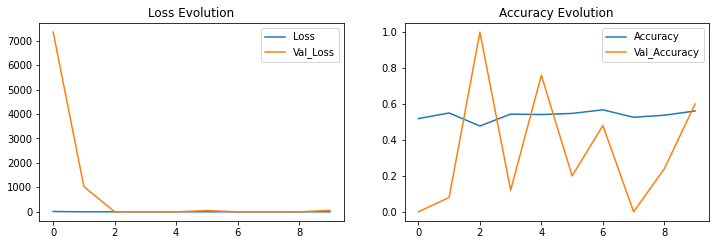

In [40]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

## Transfer learning

In this section, we will use transfer learning to leverage a powerful pretrained model, called DenseNet, to improve our accuracy

In [41]:
from keras.applications.densenet import DenseNet121
from keras import backend as K

base_model = DenseNet121(input_shape=(320, 320, 3), include_top=False, weights='imagenet', pooling='avg')


In [42]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")

print(f"The input shape {base_model.input}")
print(f"The output shape {base_model.output}")

The model has 428 layers
The input shape KerasTensor(type_spec=TensorSpec(shape=(None, 320, 320, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
The output shape KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), name='avg_pool/Mean:0', description="created by layer 'avg_pool'")


In [43]:
train.class_mode

'binary'

In [44]:
model = Sequential()
model.add(base_model)
# model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

r = model.fit(
    train, 
    epochs=10,
    validation_data=validation,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10


2022-07-13 17:32:51.089043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.6572 - accuracy: 0.6887

2022-07-13 17:34:06.633441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 84s 725ms/step - loss: 0.6572 - accuracy: 0.6887 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
100/100 [==============================] - 70s 691ms/step - loss: 0.5877 - accuracy: 0.7037 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
100/100 [==============================] - 69s 687ms/step - loss: 0.5179 - accuracy: 0.7537 - val_loss: 114.1828 - val_accuracy: 0.0000e+00
Epoch 4/10
100/100 [==============================] - 69s 685ms/step - loss: 0.5332 - accuracy: 0.7450 - val_loss: 0.3002 - val_accuracy: 0.9200
Epoch 5/10
100/100 [==============================] - 69s 686ms/step - loss: 0.4224 - accuracy: 0.8025 - val_loss: 1.2320 - val_accuracy: 0.7600
Epoch 6/10
100/100 [==============================] - 68s 680ms/step - loss: 0.4498 - accuracy: 0.7975 - val_loss: 1.1934 - val_accuracy: 0.7200
Epoch 7/10
100/100 [==============================] - 67s 673ms/step - loss: 0.4087 - accuracy: 0.8150 - val_loss: 226.9656 - v

Text(0.5, 1.0, 'Accuracy Evolution')

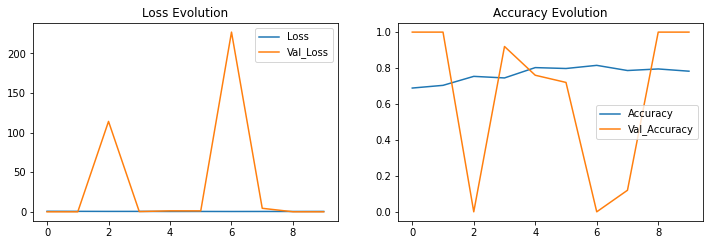

In [45]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [46]:
predicted_vals = model.predict(test, steps=len(test))

2022-07-13 17:44:25.594075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12500/12500 [==============================] - 358s 29ms/step


In [47]:
predicted_vals

array([[1.6830338e-06],
       [1.1947200e-04],
       [1.4221754e-12],
       ...,
       [3.3464440e-09],
       [1.6560999e-04],
       [1.8777311e-06]], dtype=float32)